In [1]:
import numpy as np 
import healpy as hp
import matplotlib.pyplot as plt
import mylib
from tqdm import tqdm
from importlib import reload
import pymaster as nmt
import mylib

In [2]:
nside = 256
lmax = 3*nside - 1
npix = 12 * nside**2
bin_size = 20
nmc = 100

ell_input, TT, TE, EE, BB, PP = np.loadtxt('cl.txt', unpack=True)
c2d = ell_input*(ell_input+1)/2/np.pi
# input_cls = np.array([TT, EE, np.zeros_like(EE), TE]) #no BB
input_cls = np.array([TT, EE, BB, TE]) 
input_cls /= c2d 
for c in input_cls: c[0] = 0 
input_cls = input_cls[:,:lmax+1]
c2d = c2d[:lmax+1]

/tmp/ipykernel_37889/83873468.py:11: RuntimeWarning: invalid value encountered in divide
  input_cls /= c2d


In [3]:
noise = np.zeros((nmc, 3, npix))
transfer = np.zeros((nmc,3,npix))
full = np.zeros((nmc, 3, npix))
planck = np.zeros((nmc, 3, npix))
lb = np.zeros((nmc, 3, npix))

prefix='template'
hits = hp.read_map('small_hits.fits')
for mc in tqdm(range(nmc)):
    noise[mc] = hp.read_map(f'{prefix}/noise/out/{mc+1000}/filterbin_filtered_map.fits', field=None)
    transfer[mc] = hp.read_map(f'{prefix}/transfer/out/{mc+1000}/filterbin_filtered_map.fits', field=None)
    full[mc] = hp.read_map(f'{prefix}/lensingBB/out/{mc}/filterbin_filtered_map.fits', field=None)
    # full[mc] = hp.read_map(f'{prefix}/noBB/out/{mc}/filterbin_filtered_map.fits', field=None)
    # full[mc] = hp.read_map(f'{prefix}/leakage/out/{mc}/filterbin_filtered_map.fits', field=None)
    planck[mc] = hp.read_map(f'input_maps/planck_like_E_maps/map_{mc}.fits', field=None) - hp.read_map(f'{prefix}/planck/out/{mc}/filterbin_filtered_map.fits', field=None)
    lb[mc] = hp.read_map(f'input_maps/lb_like_E_maps/map_{mc}.fits', field=None) - hp.read_map(f'{prefix}/lb/out/{mc}/filterbin_filtered_map.fits', field=None)

100%|█████████████████████████████████████████████████████████████████| 100/100 [05:15<00:00,  3.15s/it]


4.353459676106771


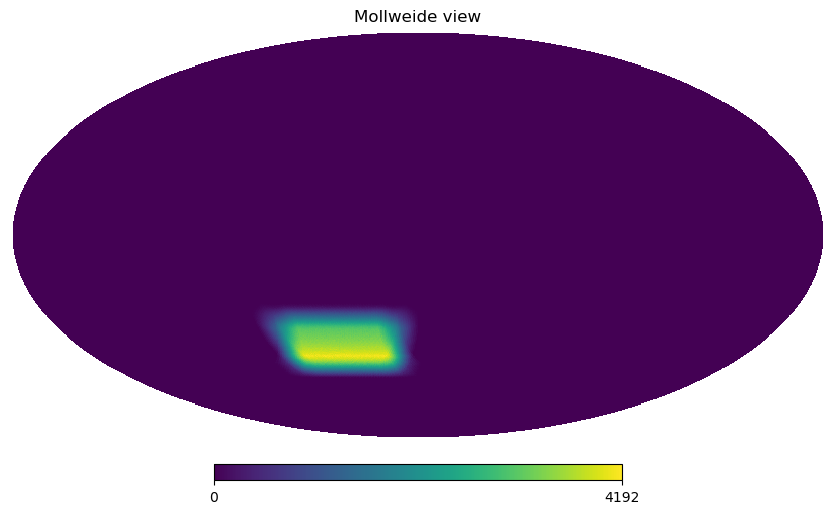

In [4]:
hp.mollview(hits)
fsky = len(hits[hits!=0])/npix
print(fsky*100)

mask = np.zeros_like(hits)
mask[hits!=0] = 1
mask_apo = nmt.mask_apodization(mask, 6, apotype='C2')
# hp.mollview(mask_apo)
w2 = np.sum(mask_apo**2)/np.sum(mask)
w4 = np.sum(mask_apo**4)/np.sum(mask)

b = nmt.NmtBin.from_nside_linear(nside, bin_size)
ells = b.get_effective_ells()
c2db = ells * (ells+1) /2/np.pi
mll,_ = mylib.get_mll(mask_apo, nside, b, pol=False)
bl = hp.gauss_beam(np.deg2rad(17/60), lmax) #sat 145ghz

In [5]:
reload(mylib)
pcl_bb_vec = np.empty((nmc, lmax+1))
pnl_vec = np.empty((nmc, 6, lmax+1))

for i in tqdm(range(nmc)):
    pcl_bb_vec[i] = hp.anafast(mask_apo*transfer[i])[2]
    pnl_vec[i] = hp.anafast(mask_apo*noise[i])
    
pcl_bb = np.mean(pcl_bb_vec, axis=0)
pnl = np.mean(pnl_vec, axis=0)
pnl_pol = np.array([pnl[1], pnl[4], pnl[4], pnl[2]]) #EE, EB, BE, BB for namaster format

100%|█████████████████████████████████████████████████████████████████| 100/100 [03:22<00:00,  2.02s/it]


In [6]:
reload(mylib)
fl_bb = mylib.get_fl(input_cls[2], pcl_bb, bl, mll)

Text(0.5, 0, 'ell')

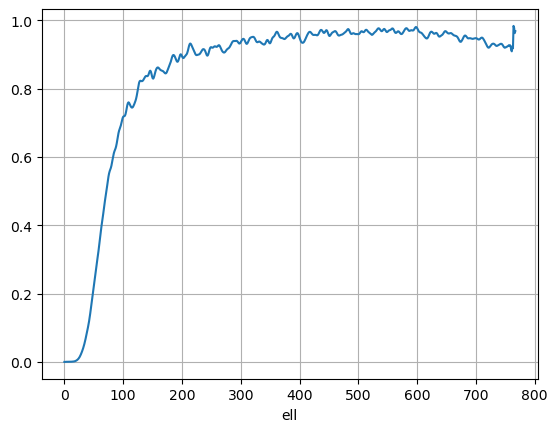

In [7]:
plt.plot(fl_bb)
# plt.xlim([0, 140])
# plt.ylim([0, 1])
plt.grid()
plt.xlabel('ell')
# plt.loglog()

In [8]:
w_KS = nmt.NmtWorkspace()
f_KS = nmt.NmtField(mask_apo, np.empty((2, npix)), beam=bl*np.sqrt(fl_bb), purify_b=True)
w_KS.compute_coupling_matrix(f_KS, f_KS, b)

w_PCL = nmt.NmtWorkspace()
f_PCL = nmt.NmtField(mask_apo, np.empty((2, npix)), beam=bl*np.sqrt(fl_bb))
w_PCL.compute_coupling_matrix(f_PCL, f_PCL, b)

w_comb = nmt.NmtWorkspace()
f_comb = nmt.NmtField(mask_apo, np.empty((1, npix)), beam=bl*np.sqrt(fl_bb))
w_comb.compute_coupling_matrix(f_comb, f_comb, b)
bpw = w_comb.get_bandpower_windows()[0,:,0]

In [9]:
cl_KS = np.empty((nmc, 4, len(ells)))
nl = np.empty((nmc, 4, len(ells)))
cl_restore_planck = np.empty((nmc, 4, len(ells)))
cl_restore_lb = np.empty((nmc, 4, len(ells)))

for mc in tqdm(range(nmc)):
    f = nmt.NmtField(mask_apo, mask*[full[mc][1], full[mc][2]], purify_b=True)
    # cl_KS[mc] = nmt.compute_full_master(f, f, b, workspace=w_KS)
    cl_KS[mc] = nmt.compute_full_master(f, f, b, pnl_pol, workspace=w_KS)
    
    f = nmt.NmtField(mask_apo, mask*[noise[mc][1], noise[mc][2]])
    nl[mc] = nmt.compute_full_master(f, f, b, workspace=w_PCL)

    restored_map = full[mc] + planck[mc]
    B_map = hp.alm2map(hp.map2alm(restored_map)[2], nside)
    f = nmt.NmtField(mask_apo, mask*[B_map])
    # cl_restore_planck[mc] = nmt.compute_full_master(f, f, b, workspace=w_comb)[0]
    cl_restore_planck[mc] = nmt.compute_full_master(f, f, b, [pnl[2]], workspace=w_comb)[0]

    restored_map = full[mc] + lb[mc]
    B_map = hp.alm2map(hp.map2alm(restored_map)[2], nside)
    f = nmt.NmtField(mask_apo, mask*[B_map])
    # cl_restore_lb[mc] = nmt.compute_full_master(f, f, b, workspace=w_comb)[0]
    cl_restore_lb[mc] = nmt.compute_full_master(f, f, b, [pnl[2]], workspace=w_comb)[0]

mean_KS = c2db * np.mean(cl_KS, axis=0)
std_KS = c2db * np.std(cl_KS, axis=0)

mean_restore_planck = c2db * np.mean(cl_restore_planck, axis=0)
std_restore_planck = c2db * np.std(cl_restore_planck, axis=0)

mean_restore_lb = c2db * np.mean(cl_restore_lb, axis=0)
std_restore_lb = c2db * np.std(cl_restore_lb, axis=0)

mean_nl = np.mean(nl, axis=0)
std_nl = np.std(nl, axis=0)

100%|█████████████████████████████████████████████████████████████████| 100/100 [09:59<00:00,  6.00s/it]


/scratch/yuyang/filterbin/mylib.py:81: RuntimeWarning: divide by zero encountered in power
  Nl = n * (l/knee)**alpha + n


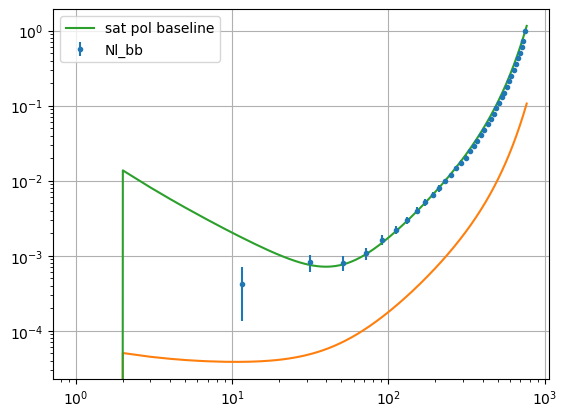

In [10]:
planck_P_noise_props = [50, 20, -1.4]
Nl_P_planck = mylib.get_Nl(planck_P_noise_props, lmax)

lb_P_noise_props = [2.5, 0, 0]
Nl_P_lb = mylib.get_Nl(lb_P_noise_props, lmax)

sat_pol_baseline = mylib.get_Nl([3.3, 50, -3], lmax)/bl**2
# sat_pol_optimal = mylib.get_Nl([np.sqrt(2)*2.1, 25, -3], lmax)/bl**2
test = mylib.get_Nl([1, 50, -2], lmax)/bl**2

plt.errorbar(ells, c2db*mean_nl[3], yerr=c2db*std_nl[3], fmt='.', label='Nl_bb')
plt.plot(c2d*test)
plt.plot(c2d*sat_pol_baseline, label='sat pol baseline')

plt.legend()
plt.loglog()
plt.grid()

/tmp/ipykernel_37889/3559022902.py:2: RuntimeWarning: invalid value encountered in sqrt
  knox = (bpw@input_cls[2] + mean_nl[3]) * np.sqrt(2/(bpw@nu_l))


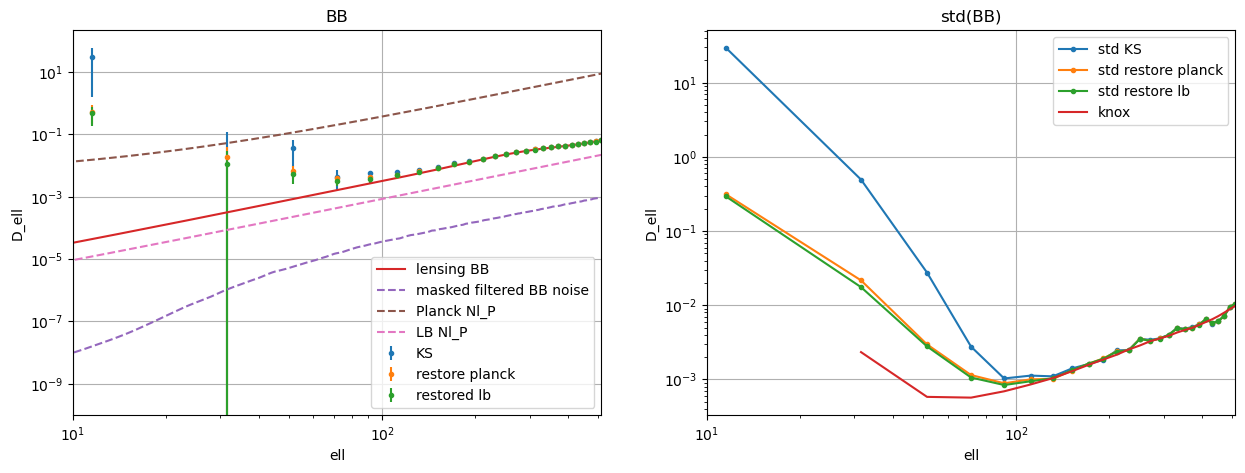

In [11]:
nu_l = (2*np.arange(lmax+1)+1)*fsky*w2**2/w4*bin_size*fl_bb
knox = (bpw@input_cls[2] + mean_nl[3]) * np.sqrt(2/(bpw@nu_l))

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].errorbar(ells, mean_KS[3], yerr=std_KS[3], fmt='.', label='KS')
# axes[0].errorbar(ells, mean_KS[0], yerr=std_KS[0], fmt='.', label='EE')
# axes[0].errorbar(ells, c2db*mean_nl[3], yerr=c2db*std_nl[3], fmt='.', label='Nl_bb')

axes[0].errorbar(ells, mean_restore_planck[3], yerr=std_restore_planck[3], fmt='.', label='restore planck')
axes[0].errorbar(ells, mean_restore_lb[3], yerr=std_restore_lb[3], fmt='.', label='restored lb')
axes[0].plot(ell_input, BB, label='lensing BB')

axes[0].plot(c2d*pnl[2], label='masked filtered BB noise', linestyle='dashed')
axes[0].plot(c2d*Nl_P_planck, label='Planck Nl_P', linestyle='dashed')
axes[0].plot(c2d*Nl_P_lb, label='LB Nl_P', linestyle='dashed')

axes[0].set_title('BB')


axes[1].plot(ells, std_KS[3], marker='.',label='std KS')
# axes[1].plot(ells, std_noleakage[3], marker='.',label='std noleakage')

axes[1].plot(ells, std_restore_planck[3], marker='.',label='std restore planck')
axes[1].plot(ells, std_restore_lb[3], marker='.',label='std restore lb')
axes[1].plot(ells, c2db*knox, label='knox')
axes[1].set_title('std(BB)')
# axes[1].set_ylim([1e-5,1e0])

for ax in axes.flatten():
    ax.legend()
    ax.set_xlim([10,2*nside])
    ax.loglog()
    ax.grid()
    ax.set_xlabel('ell')
    ax.set_ylabel('D_ell')

In [12]:
import camb
pars = camb.read_ini('https://raw.githubusercontent.com/cmbant/CAMB/master/inifiles/planck_2018.ini')
pars.WantTensors=True
pars.InitPower.set_params(r=1)
results = camb.get_results(pars)
cl = results.get_tensor_cls(CMB_unit='muK', raw_cl=True)
cl_r1 = np.pad(np.array([cl[:,i] for i in range(4)]), ((0,0),(0,lmax+1-cl.shape[0])))

In [13]:
sigma_r_KS = np.empty(nmc)
sigma_r_planck = np.empty(nmc)
sigma_r_lb = np.empty(nmc)

cl_BB_r1 = bpw@cl_r1[2] 

for i in range(nmc):
    sigma_r_KS[i] = 1/np.sqrt(fsky/2 * np.sum( (2*ells+1) * (cl_BB_r1 / cl_KS[i][3])**2 )) 
    sigma_r_planck[i] = 1/np.sqrt(fsky/2 * np.sum( (2*ells+1) * (cl_BB_r1 / cl_restore_planck[i][3])**2 )) 
    sigma_r_lb[i] = 1/np.sqrt(fsky/2 * np.sum( (2*ells+1) * (cl_BB_r1 / cl_restore_lb[i][3])**2 )) 

Text(0, 0.5, '# MC')

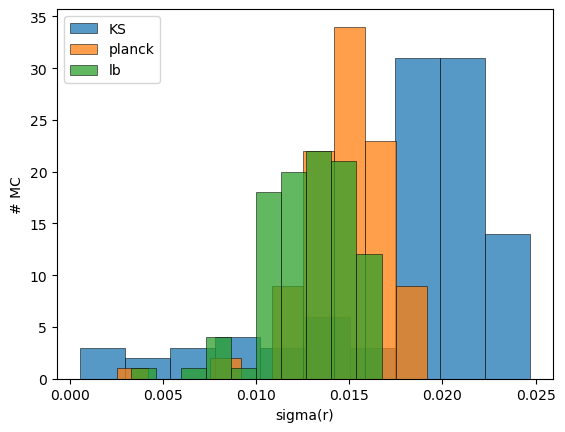

In [14]:
plt.hist(sigma_r_KS, label='KS', alpha=0.75, edgecolor='black', linewidth=0.5)
plt.hist(sigma_r_planck, label='planck', alpha=0.75,edgecolor='black', linewidth=0.5)
plt.hist(sigma_r_lb, label='lb', alpha=0.75,edgecolor='black', linewidth=0.5)

plt.legend()
# plt.ylim([0, 40])
# plt.grid()
plt.xlabel('sigma(r)')
plt.ylabel('# MC')

In [15]:
np.median(sigma_r_KS), np.median(sigma_r_planck), np.median(sigma_r_lb)

(0.019701270669211346, 0.015010860898170714, 0.012904090257413865)